#  Minimum Spanning Tree Problem 
## Complete Subtour Elimination Constraints (SEC) formulation  

This formulation contains all SEC inequalities.
See slides **trees.pdf** for details


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
#import pygraphviz as pygv
import os
from IPython.display import SVG, display


In [ ]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos, width=0.1, fontsize=9)
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    

def DrawSol (x):
    for i,j in G.edges():
        lab = x[i,j].x
        G[i][j]['capacity'] = x[i,j].x
        if x[i,j].x > 0.00001:
            if x[i,j].x > 0.999999:
                DrawG.add_edge(i, j, color='black', label=lab, fontsize=9)
            else:
                DrawG.add_edge(i, j, color='red', label=lab)
    path=str(basename)+'_sol.svg'
    DrawG.draw (path=path, format='svg')
    DrawG.delete_edges_from(DrawG.edges())

In [5]:
class args:
    filename = None
    scale = 40

In [6]:
args.filename = "graph.gml"
args.scale = 20

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 90 edges


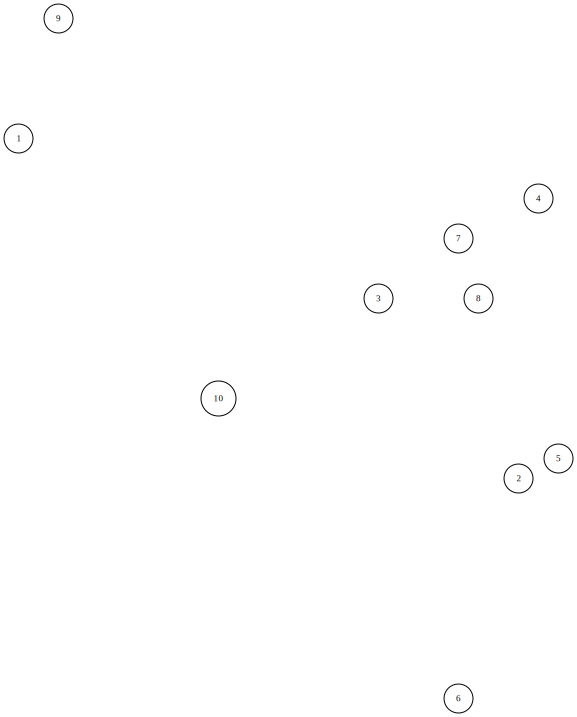

In [4]:
DrawInitialGraph()
display(SVG(filename=basename+'.svg'))



### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [7]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), \
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS,\
                name='x')


#cost={(u,v):G.edge[u][v]['cost'] for u,v in G.edges()}
mst.setObjective(x.prod(cost))

mst.update()

mst.write('mst.lp')


KeyError: 'cost'

In [6]:
# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

## Subtour elimination constraints

In [7]:
sec = 0

for i in powerset(G.nodes()):
    if len(i) > 2 and len(i) <= G.number_of_nodes() - 1:
        sec += 1
        S = G.subgraph(i)
        if S.number_of_edges() > S.number_of_nodes() - 1:
            
            # Add only edges existing in S 
            # NOTE 
            # a variable key error may arise without  
            # the conditional statement (edge are undirected)
            # 

                
            mst.addConstr(gb.quicksum(x[i,j] \
                                      if (i,j) in x else x[j,i] \
                                      for i,j in S.edges()) \
                          <= S.number_of_nodes() - 1, 'Sec' + str(sec))
            
            
mst.update()
mst.write('mst.lp')

print ("Number of Subtour Elimination Constraints:", sec)


Number of Subtour Elimination Constraints: 967


In [8]:

mst.optimize()

print ("Optimal solution:", mst.objVal)
DrawSol(x)


Optimize a model with 968 rows, 45 columns and 11475 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 9e+00]
Presolve time: 0.01s
Presolved: 45 rows, 1013 columns, 11520 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   9.000000e+00      0s
      22    6.7350000e+03   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.02 seconds
Optimal objective  6.735000000e+03
Optimal solution: 6735.0


In [9]:
x

{(1, 2): <gurobi.Var x[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var x[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var x[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var x[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var x[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var x[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var x[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var x[1,9] (value 1.0)>,
 (1, 10): <gurobi.Var x[1,10] (value 1.0)>,
 (2, 3): <gurobi.Var x[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var x[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var x[2,5] (value 1.0)>,
 (2, 6): <gurobi.Var x[2,6] (value 1.0)>,
 (2, 7): <gurobi.Var x[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var x[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var x[2,9] (value 0.0)>,
 (2, 10): <gurobi.Var x[2,10] (value 0.0)>,
 (3, 4): <gurobi.Var x[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var x[3,5] (value 0.0)>,
 (3, 6): <gurobi.Var x[3,6] (value 0.0)>,
 (3, 7): <gurobi.Var x[3,7] (value 0.0)>,
 (3, 8): <gurobi.Var x[3,8] (value 1.0)>,
 (3, 9): <gurobi.Var x[3,9] (value 0.0)>,
 (3, 10): <gurobi.Var x[3,10] 

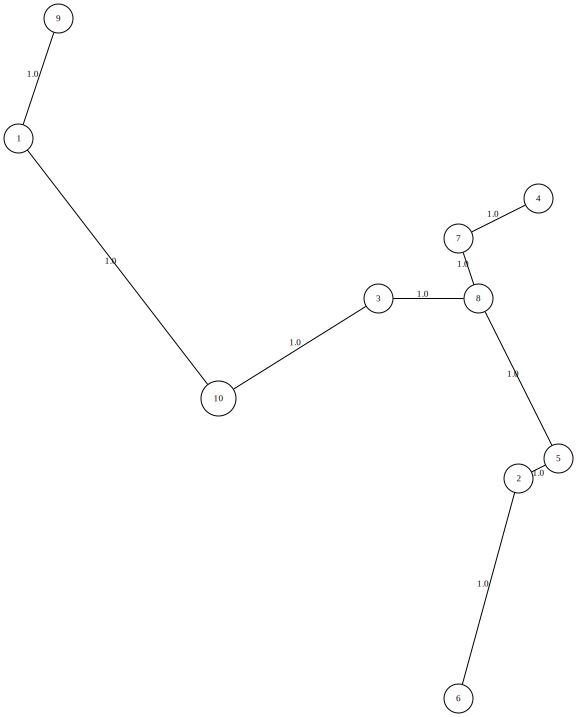

In [10]:
display(SVG(filename=basename+'_sol.svg'))


## Subtour Elimination Constraints formulation (SEC): separation problem

### Problem formulation

$$
\max \sum_{e=\{i,j\} \in E} x^*_e w_{ij} - \sum_{j \in V} z_j \\
w_{ij} - z_i \le 0,\; w_{ij} - z_j \le 0 \;\;\; \forall \{i,j\} \in E\\
z_k = 1\\
0 \le z \le 1, 0 \le w \le 1
$$

In [11]:
#
# Subtour Elimination Constraints: separation
# 

def SECseparation (x, G, node):
    
    #
    # Definition of the separation problem
    #
    
    SECsep = gb.Model()
    
    #
    # Variables w_ij and z_i
    #
    
    w = SECsep.addVars(G.edges(), \
                       obj=[x[u,v].x for u,v in G.edges()], \
                       ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='w')
        
    z= SECsep.addVars(G.nodes(), \
                      obj = -1.0, \
                      ub = 1.0, \
                  vtype=gb.GRB.CONTINUOUS, name='z')

    #
    # Objective function
    #

    SECsep.ModelSense = -1
    
    #
    # Constraints
    #

    SECsep.addConstrs((w[i,j] - z[i] <= 0 \
                       for i,j in G.edges()), name = 'WZ1')
    
    SECsep.addConstrs((w[i,j] - z[j] <= 0 \
                       for i,j in G.edges()), name = 'WZ2')
    
    SECsep.addConstr(z[node] == 1, name="Fixing")
    
    SECsep.update()
    
    SECsep.write('sep.lp')

    SECsep.optimize()

    if (SECsep.objVal) > -1.0:
        SEC = [i for i in G.nodes() if z[i].x > 0.1]
        return True, SEC
    else:
        return False, None


## Master problem 

The master problem now contains only the cardinality constraint


In [12]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()], ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [13]:
mst.optimize()

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]
Presolve removed 0 rows and 3 columns
Presolve time: 0.01s
Presolved: 1 rows, 42 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0070000e+03   8.000000e+00   0.000000e+00      0s
       1    5.0160000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.016000000e+03


In [14]:
for i in x:
    if x[i].x > 0:
        print (x[i])

<gurobi.Var x[1,9] (value 1.0)>
<gurobi.Var x[2,5] (value 1.0)>
<gurobi.Var x[2,8] (value 1.0)>
<gurobi.Var x[3,7] (value 1.0)>
<gurobi.Var x[3,8] (value 1.0)>
<gurobi.Var x[4,7] (value 1.0)>
<gurobi.Var x[4,8] (value 1.0)>
<gurobi.Var x[5,8] (value 1.0)>
<gurobi.Var x[7,8] (value 1.0)>


## Cutting plane algorithm

Now the cutting plane algorithm. At each iteration, after the resolution of the master LP (note, the relaxation) a sequence of separation problems are solved
and if there exists a violated SEC then it is added to the master. The cutting plane is interactive, thus press ``Enter`` key to continue.

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.016000000e+03
Current solution value: 5016.0


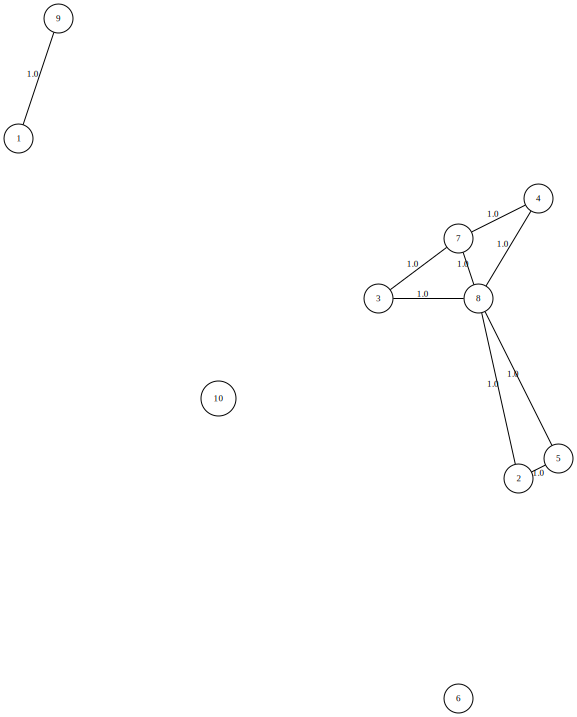

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 41 columns
Presolve time: 0.01s
Presolved: 16 rows, 14 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   4.000000e+00   0.000000e+00      0s
       6    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds
Optimal objective  1.000000000e+00
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8]
Press Enter to continue...

Optimize a model with 2 rows, 45 columns and 66 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0160000e+03   2.000000e+00   0.000

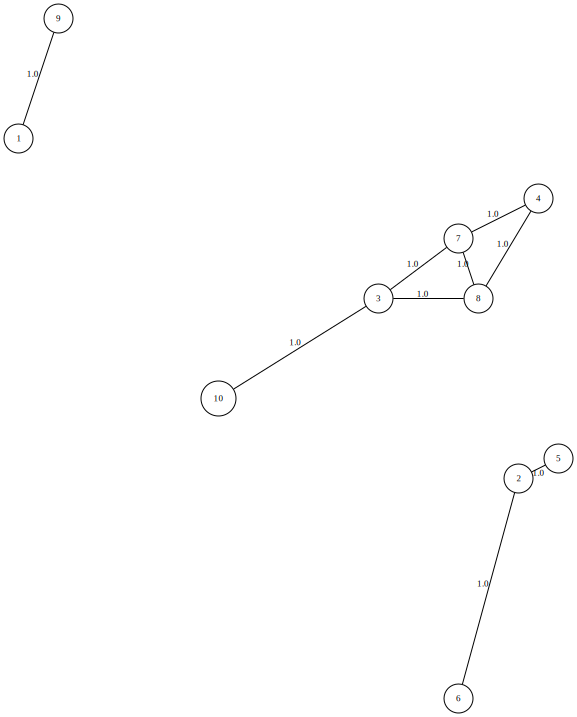

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 81 rows and 46 columns
Presolve time: 0.01s
Presolved: 10 rows, 9 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       4   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.02 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8]
Press Enter to continue...

Optimize a model with 3 rows, 45 columns and 76 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2840000e+03   1.000000e+00   0.000000e+00

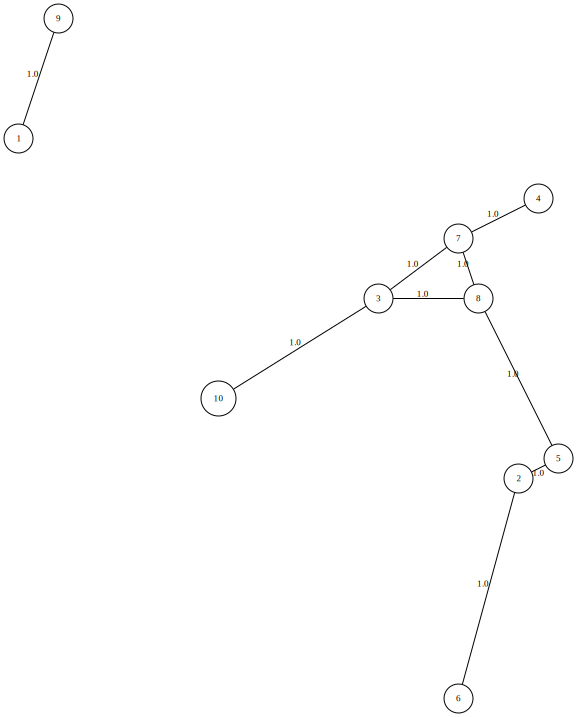

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

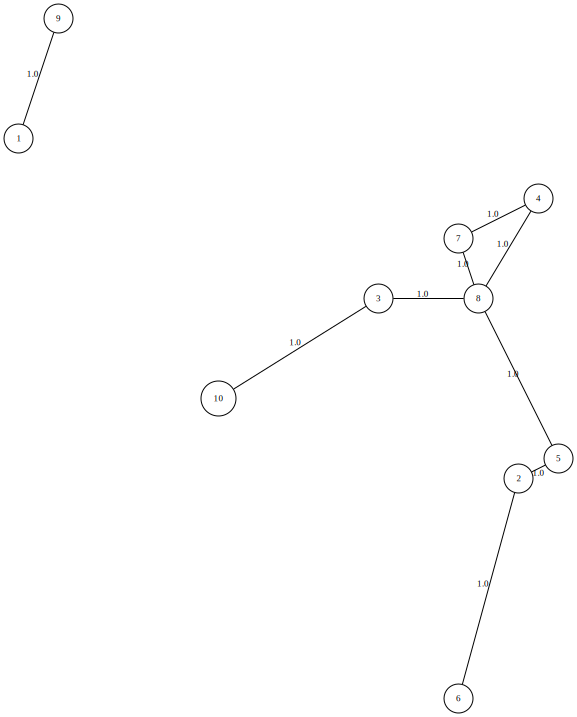

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.02s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

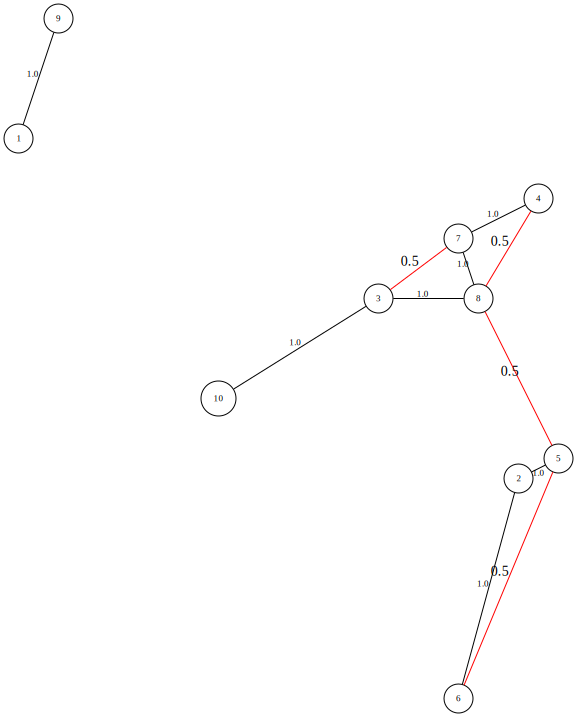

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.01s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 81 rows and 46 columns
Presolve time: 0.01s
Presolved: 10 rows, 9 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.00000

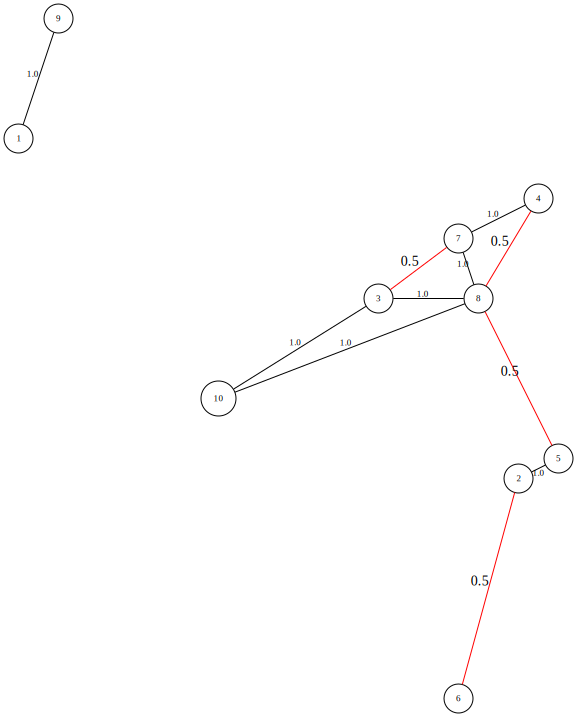

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 77 rows and 43 columns
Presolve time: 0.01s
Presolved: 14 rows, 12 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   4.000000e+00   0.000000e+00      0s
       4   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.02 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8, 10]
Press Enter to continue...

Optimize a model with 7 rows, 45 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0115000e+03   1.000000e+00   0.0000

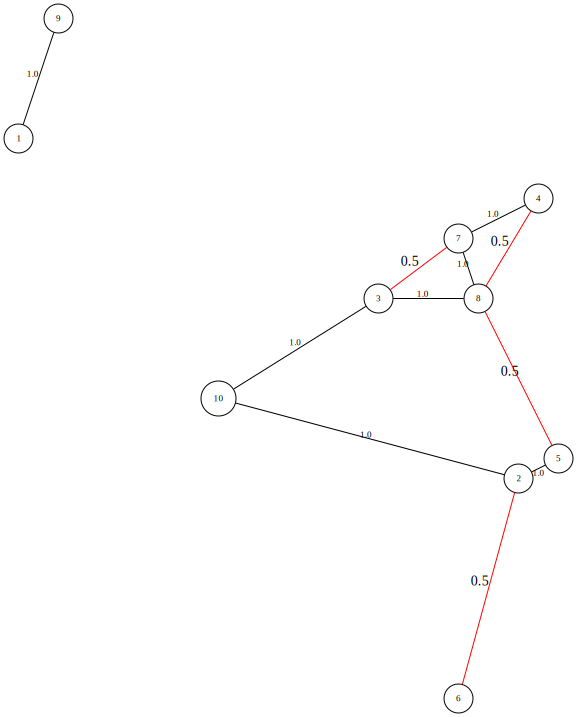

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.02s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       6   -5.0000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.05 seconds
Optimal objective -5.000000000e-01
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8, 10]
Press Enter to continue...

Optimize a model with 8 rows, 45 columns and 160 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 9e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1715000e+03   5.000000e-01   

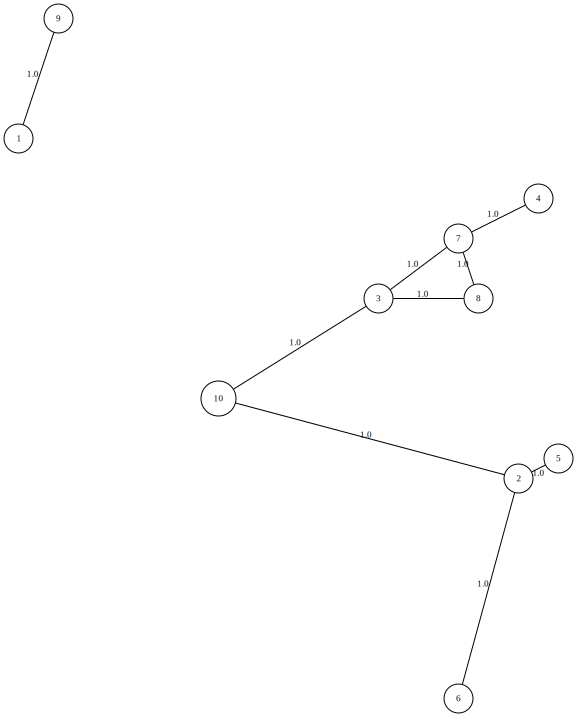

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.03s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

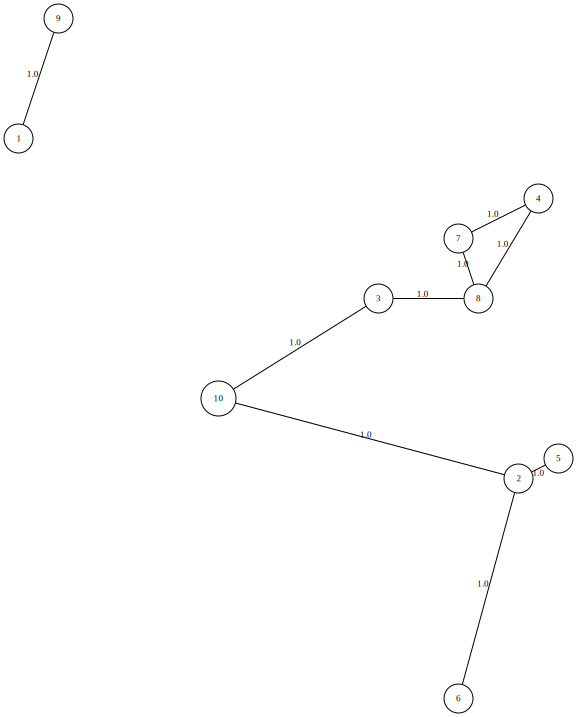

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

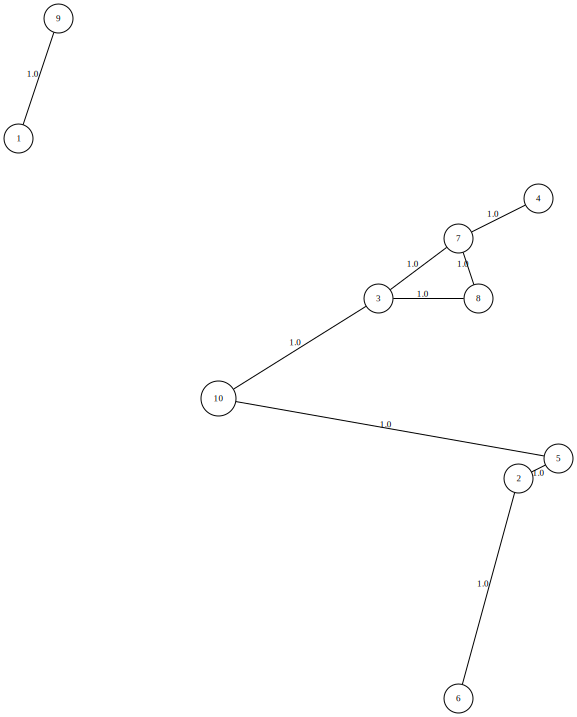

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

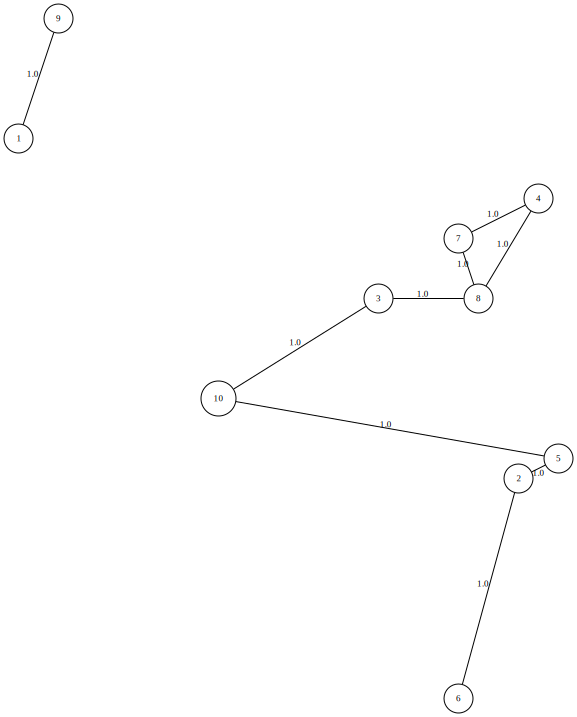

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

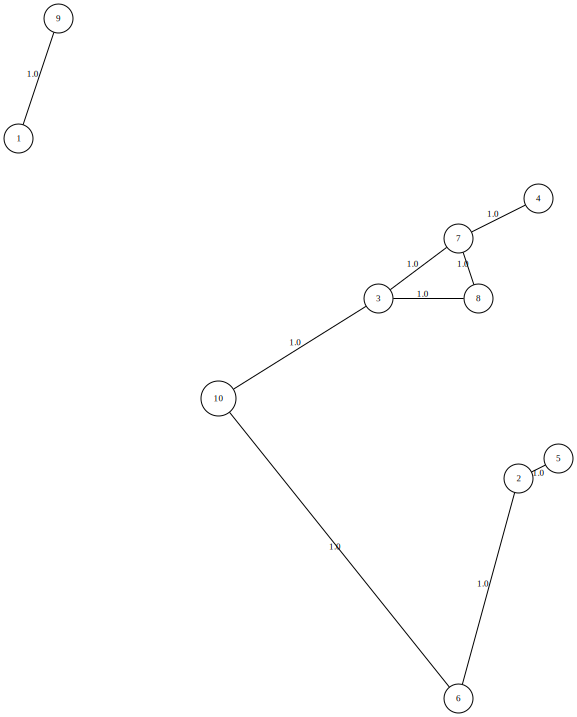

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

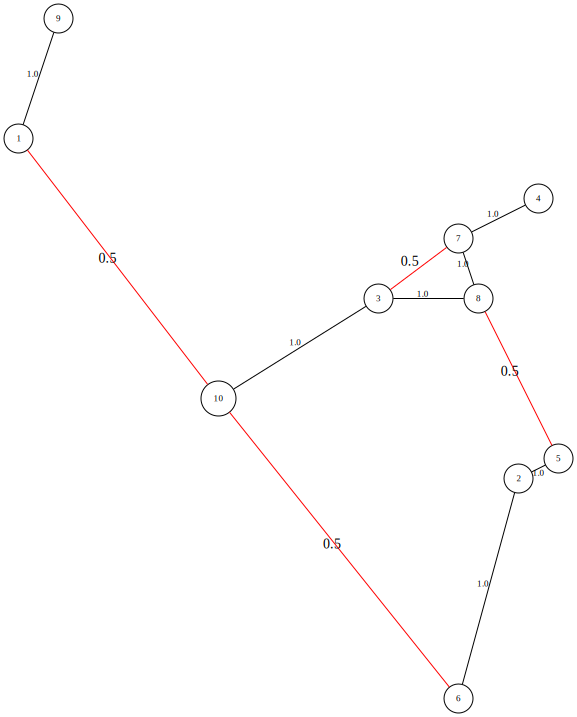

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 40 columns
Presolve time: 0.03s
Presolved: 16 rows, 15 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.04 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.04s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.000000

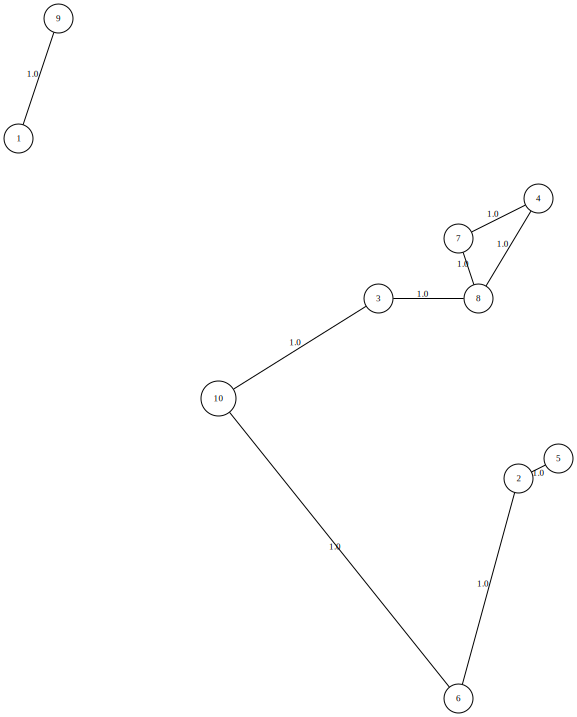

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

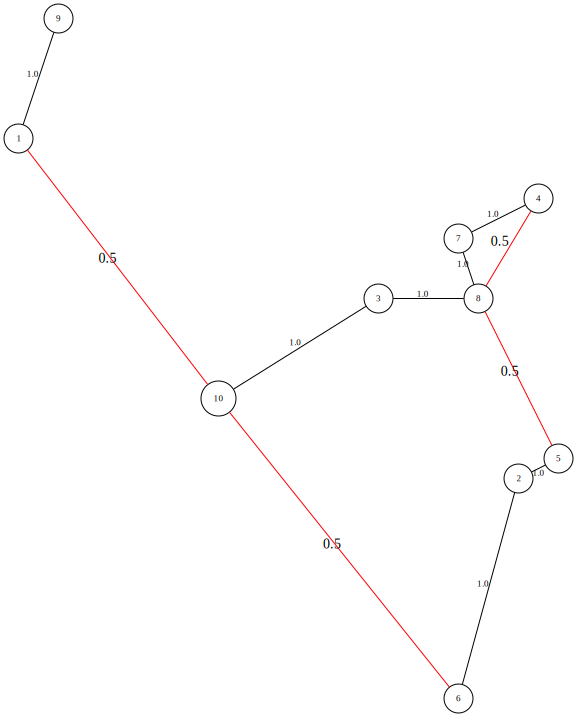

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 38 columns
Presolve time: 0.01s
Presolved: 18 rows, 17 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0000000e-0

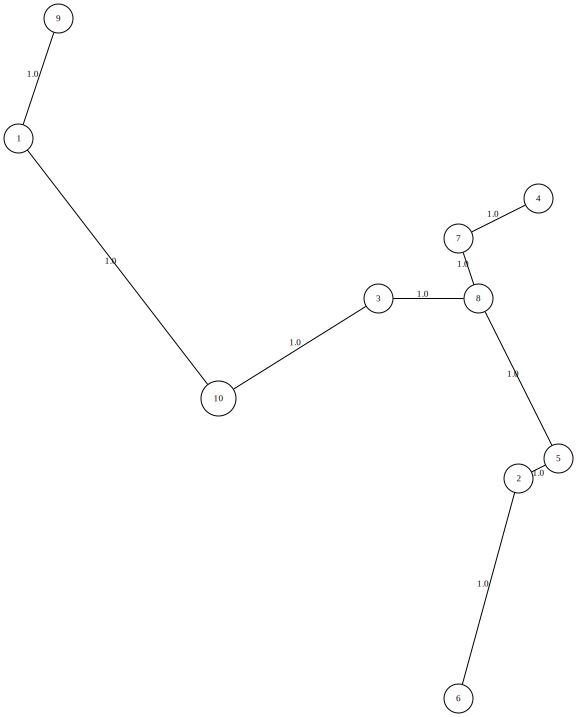

Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -1.000000000e+00
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.

In [15]:


cont = True
#ftime = True

#
# Main cutting plane algorithm
#

sec = 1

while cont: 
    mst.optimize()
    print ("Current solution value:", mst.objVal)

    DrawSol(x)
    display(SVG(filename=basename+'_sol.svg'))


    cont = False
    for u in G.nodes():
        status, SEC = SECseparation(x, G, u)
        if status:
            cont = True
            S = G.subgraph(SEC)
            
            print ("Found violated subtour. S =", S.nodes())

            #
            # Constraint is added: 
            # variable key error may arise without  
            # the conditional statement (edge are undirected)
            # 

            mst.addConstr(gb.quicksum(x[i,j] \
                                      if (i,j) in G.edges() else x[j,i] \
                                      for i,j in S.edges()) \
                                      <= S.number_of_nodes() - 1, 'Sec' + str(sec))
            
            sec += 1
            
            mst.write('mstsep.lp')
            input("Press Enter to continue...\n")       
            break

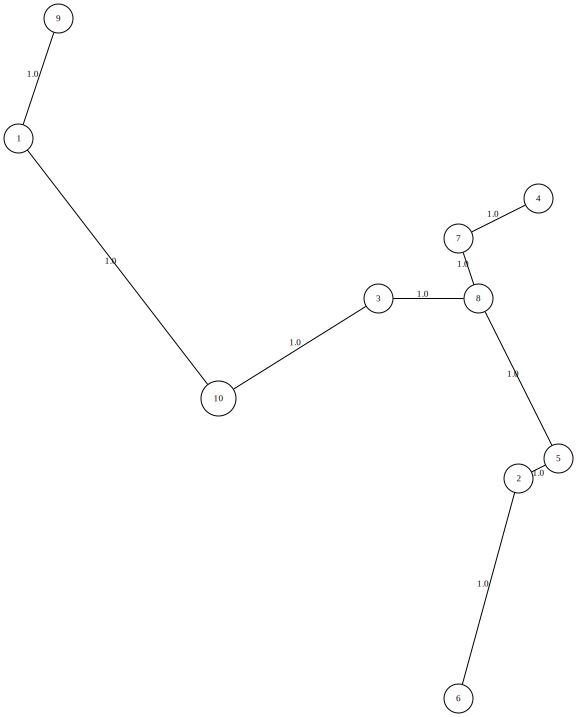

In [16]:
display(SVG(filename=basename+'_sol.svg'))

In [17]:
def DrawSolFlow (x,f):
    for i in G.edges():
        h = i[0]
        k = i[1]
        
        flow = abs(f[h,k].x - f[k,h].x)
        lab = "[" + str(x[i].x) + ", " + str(flow) + "]"
        G[h][k]['capacity'] = x[i].x
        if x[i].x > 0.00001:
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab)
            else:
                DrawG.add_edge(h, k, color='red', label=lab)
    DrawG.draw (path=str(basename) + '_sol.svg', format='svg')
    DrawG.delete_edges_from(DrawG.edges())

In [18]:
args.filename = "graph30.gml"
args.scale = 40

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


## Single commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 

$$
f_{ij} = \{\text{flow carried by the arc} (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{e \in E} x_e = n - 1 && \\
\sum_{j \in \delta^+(0)} f_{0j} - \sum_{j \in \delta^-(0)} f_{j0} = n - 1 &&\\
\sum_{j \in \delta^-(v)} f_{jv} - \sum_{j \in \delta^+(v)} f_{vj} = 1 &&\;\; \forall v \in V, v \not = \{0\} \\
f_{ij} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f_{ji} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f \ge 0, \; x_e \in \{0,1\}
\end{alignat}

In [19]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30))

In [20]:
root = 1


In [21]:
DrawInitialGraph()

D = G.to_directed()

D.edges()

OutEdgeView([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4

In [22]:
mstflow = gb.Model()

In [23]:
x = mstflow.addVars(G.edges(),\
                    obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')

f = mstflow.addVars(D.edges(),\
                    ub=G.number_of_nodes(),\
                    vtype=gb.GRB.CONTINUOUS, name='f')



In [24]:
mstflow.addConstr(x.sum() == G.number_of_nodes() - 1,\
                  'Cardinality')

mstflow.update()

In [25]:
mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) \
                  == G.number_of_nodes() - 1, \
                  'Flow_at_root')

mstflow.update()

mstflow.write('mstflow.lp')

In [26]:

for v in G.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - \
                          f.sum(v,'*') == 1, name=name)
    
mstflow.update()

mstflow.write('mstflow.lp')

In [27]:
for u,v in G.edges():
    h = u
    k = v
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, u, v)
    mstflow.addConstr(f[h,k] <= \
                      (G.number_of_nodes() - 1) * \
                      x[u,v], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, u, v)
    mstflow.addConstr(f[k,h] <= \
                      (G.number_of_nodes() - 1) * \
                      x[u,v], name=name)

mstflow.update()
mstflow.write('mstflow.lp')

In [28]:
mstflow.optimize()

Optimize a model with 901 rows, 1305 columns and 3915 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve time: 0.01s
Presolved: 901 rows, 1305 columns, 3915 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)
Found heuristic solution: objective 53163.000000

Root relaxation: objective 1.106838e+04, 1210 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11068.3793    0    9 53163.0000 11068.3793  79.2%     -    0s
H    0     0                    14486.000000 11068.3793  23.6%     -    0s
     0     0 11884.2628    0   15 14486.0000 11884.2628  18.0%     -    0s
     0     0 11985.2046    0   16 14486.0000 11985.2046  17.3%     -    0s
     0     0 11988.4

In [29]:
for i in f:
    if (f[i].x > 0):
        print (i, f[i].x) 

(1, 3) 28.0
(1, 9) 1.0
(2, 21) 1.0
(3, 7) 27.0
(4, 10) 4.000000000000002
(7, 8) 1.0
(7, 23) 25.0
(10, 25) 29.0
(11, 16) 9.0
(12, 30) 9.0
(14, 20) 13.0
(15, 18) 1.0
(16, 19) 8.0
(17, 12) 10.0
(19, 4) 5.0
(19, 27) 2.0
(20, 28) 12.0
(22, 26) 6.0
(23, 11) 10.0
(23, 14) 14.0
(24, 2) 2.0
(24, 6) 1.0
(24, 26) 25.0
(25, 10) 26.0
(25, 15) 2.0
(26, 13) 1.0
(26, 24) 29.0
(27, 5) 1.0
(28, 17) 11.0
(29, 22) 7.0
(30, 29) 8.0


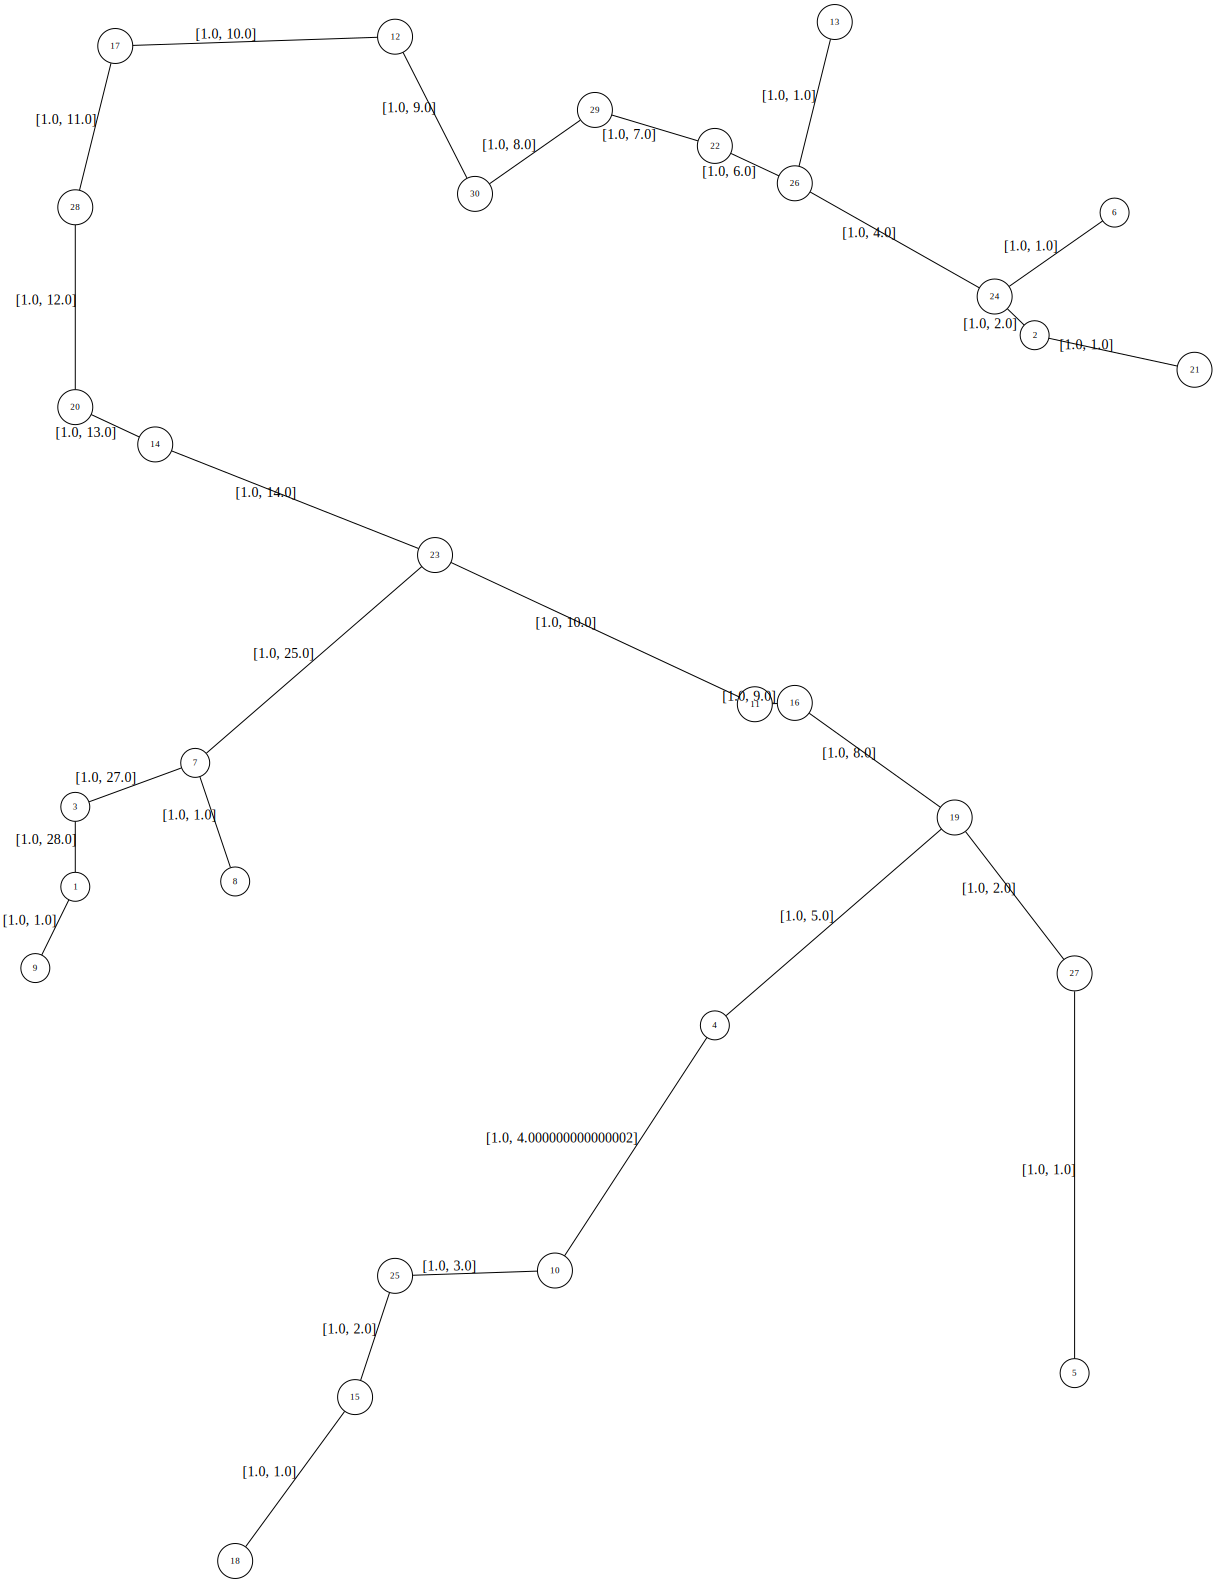

In [30]:
DrawSolFlow(x, f)

display(SVG(filename=basename+'_sol.svg'))

## Degree constrained spanning tree

In [31]:
rootdeg = 5

mstflow.addConstr(gb.quicksum([x[e] for e in G.edges(root)]), \
                  sense='=', rhs=rootdeg, name='RootDegree')


mstflow.update()

mstflow.write('mstflow.lp')

In [32]:
mstflow.optimize()

Optimize a model with 902 rows, 1305 columns and 3944 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]

MIP start did not produce a new incumbent solution
MIP start violates constraint RootDegree by 3.000000000

Presolve time: 0.01s
Presolved: 902 rows, 1305 columns, 3915 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)

Root relaxation: objective 1.142793e+04, 1303 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11427.9310    0    9          - 11427.9310      -     -    0s
H    0     0                    14808.000000 11427.9310  22.8%     -    0s
     0     0 12198.1410    0   14 14808.0000 12198.1410  17.6%     -    0s
     0     0 12269.2928    0   16 1

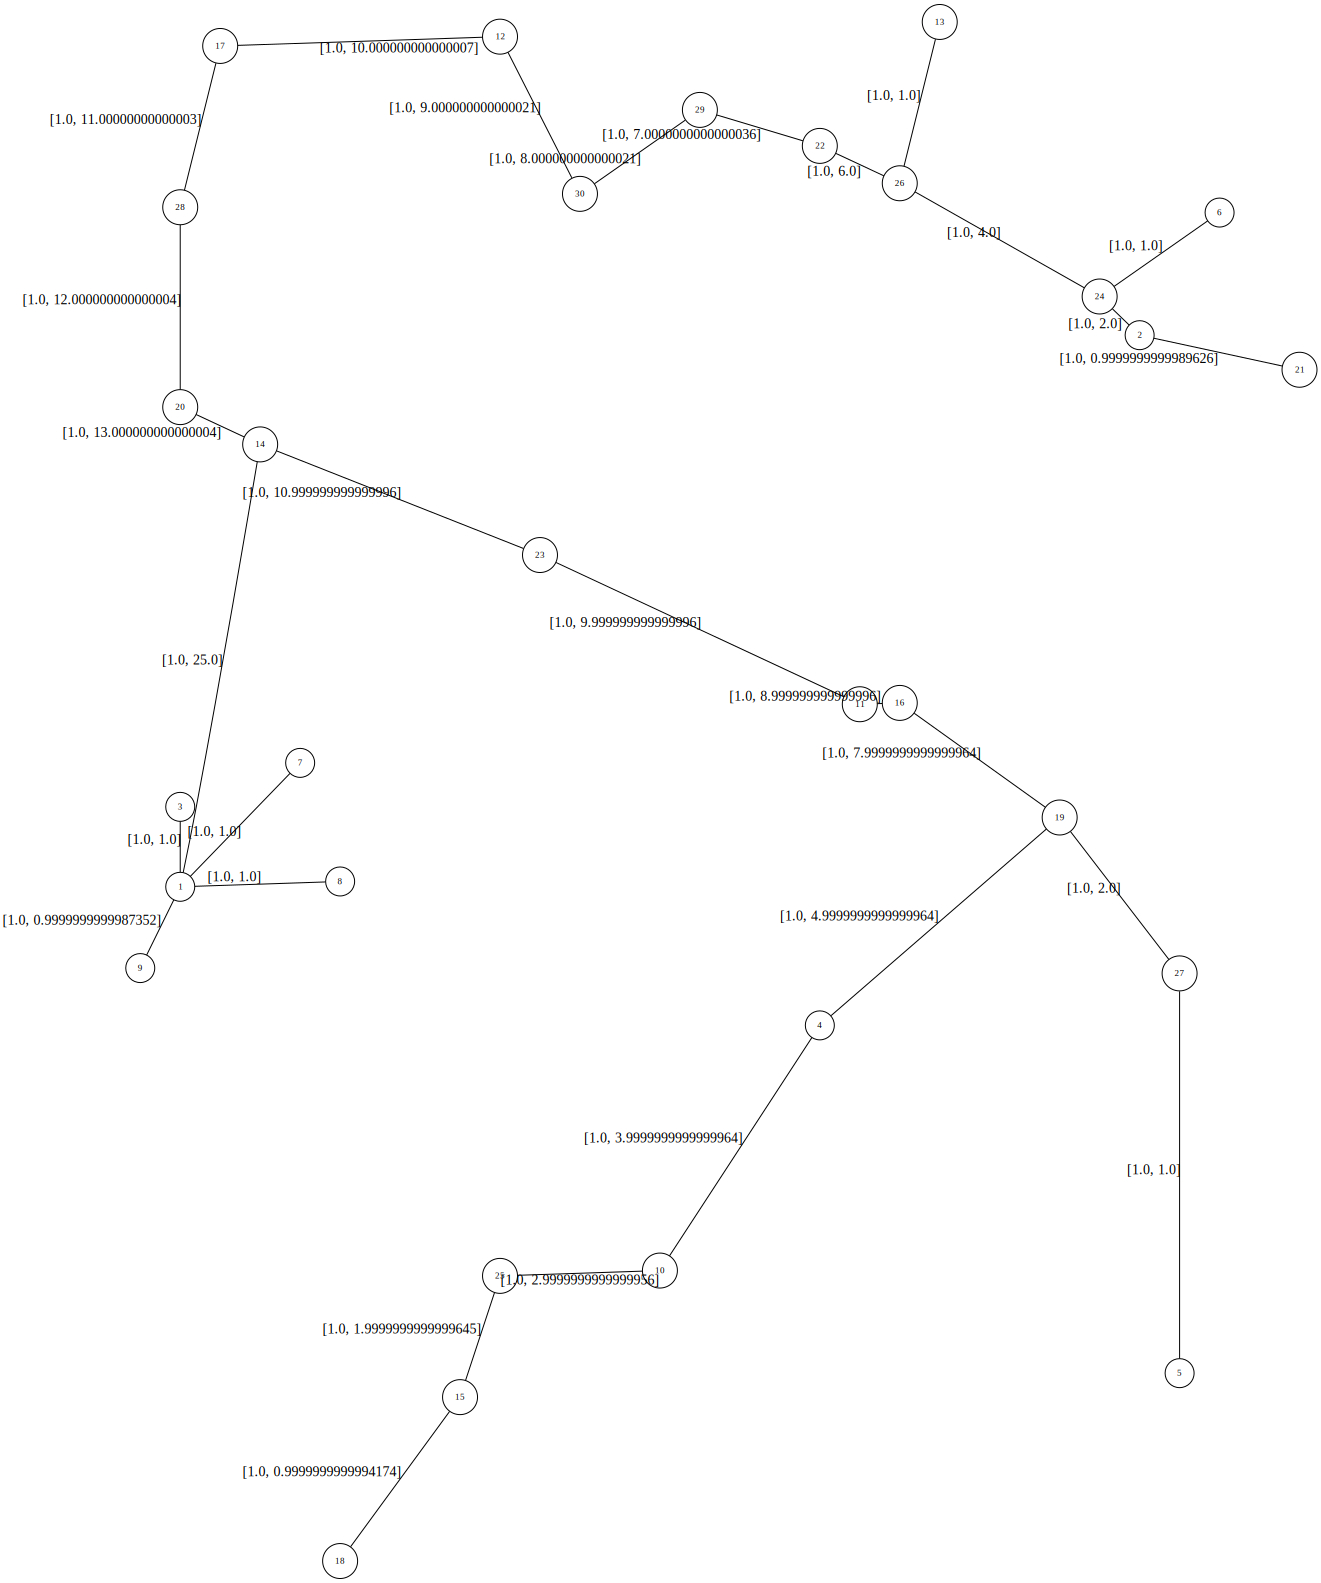

In [33]:
DrawSolFlow(x, f)

display(SVG(filename=basename+'_sol.svg'))

In [34]:
mstflow.remove(mstflow.getConstrByName('RootDegree'))

## Capacitated spanning tree

In [35]:
subtreecap = 5

for i in f:
    f[i].ub = subtreecap

In [36]:
mstflow.optimize()

Optimize a model with 901 rows, 1305 columns and 3915 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 3e+01]

MIP start did not produce a new incumbent solution

Presolve time: 0.01s
Presolved: 901 rows, 1305 columns, 3915 nonzeros
Variable types: 870 continuous, 435 integer (435 binary)
Found heuristic solution: objective 53163.000000

Root relaxation: objective 1.479700e+04, 1034 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14797.0000    0   22 53163.0000 14797.0000  72.2%     -    0s
     0     0 15802.6554    0   30 53163.0000 15802.6554  70.3%     -    0s
     0     0 15871.6922    0   30 53163.0000 15871.6922  70.1%     -    0s
     0     0 15871.6922    0   30 53163.00

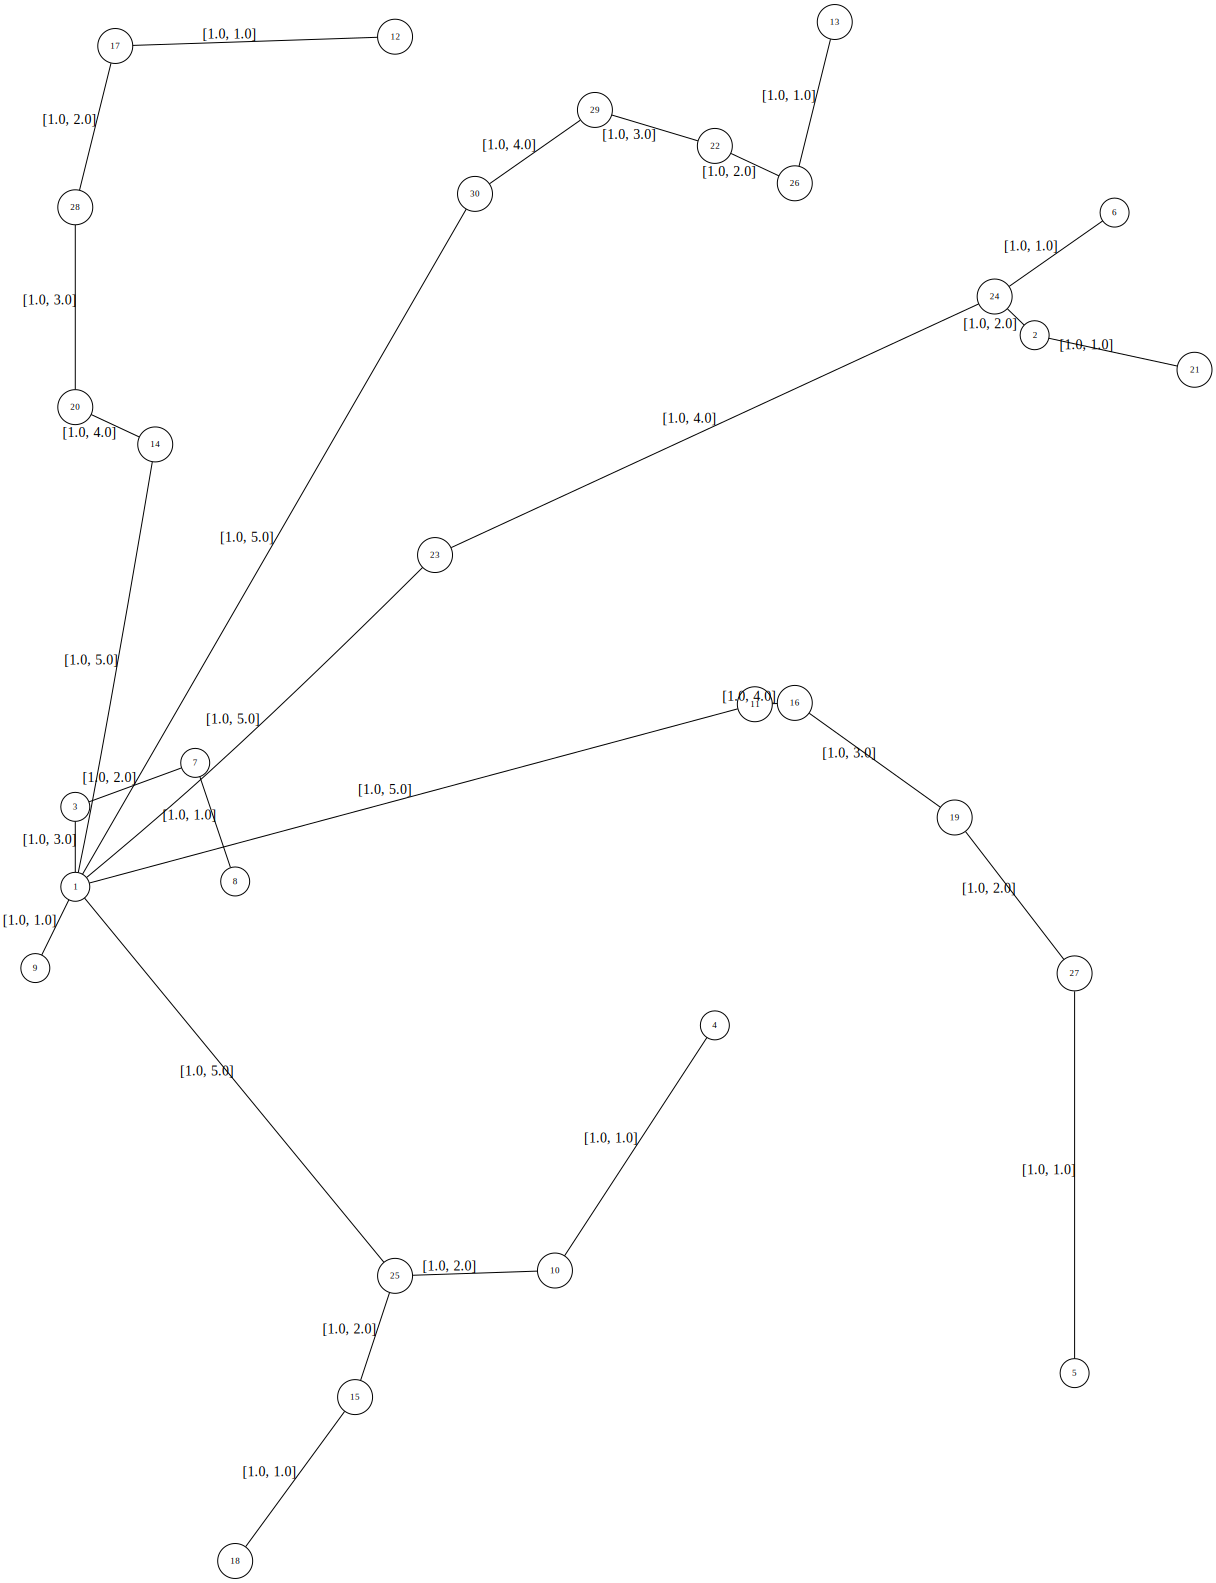

In [37]:
DrawSolFlow(x, f)

display(SVG(filename=basename+'_sol.svg'))